In [6]:
import torch
import numpy as np

In [20]:
ex = torch.from_numpy(np.array([0.2,0.8]))

In [21]:
torch.sigmoid(ex)

tensor([0.5498, 0.6900], dtype=torch.float64)

In [22]:
torch.softmax(ex, dim=0)

tensor([0.3543, 0.6457], dtype=torch.float64)

In [23]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.tri as tri

#生成等边三角形
corners = np.array([[0, 0], [1, 0], [0.5, 0.75**0.5]])
triangle = tri.Triangulation(corners[:, 0], corners[:, 1])

#每条边中点位置
midpoints = [(corners[(i + 1) % 3] + corners[(i + 2) % 3]) / 2.0 for i in range(3)]

def xy2bc(xy, tol=1.e-3):
    #将三角形顶点的笛卡尔坐标映射到重心坐标系
    s = [(corners[i] - midpoints[i]).dot(xy - midpoints[i]) / 0.75 for i in range(3)]
    return np.clip(s, tol, 1.0 - tol)

#有了重心坐标，可以计算Dirichlet概率密度函数的值
class Dirichlet(object):

    def __init__(self, alpha):
        from math import gamma
        from operator import mul
        from functools import reduce
        self._alpha = np.array(alpha)
        self._coef = gamma(np.sum(self._alpha)) / reduce(mul, [gamma(a) for a in self._alpha]) #reduce:sequence连续使用function

    def pdf(self, x):
        #返回概率密度函数值
        from operator import mul
        from functools import reduce
        return self._coef * reduce(mul, [xx ** (aa - 1) for (xx, aa)in zip(x, self._alpha)])

def draw_pdf_contours(dist, nlevels=200, subdiv=8, **kwargs):
    import math

    #细分等边三角形网格
    refiner = tri.UniformTriRefiner(triangle)
    trimesh = refiner.refine_triangulation(subdiv=subdiv)
    pvals = [dist.pdf(xy2bc(xy)) for xy in zip(trimesh.x, trimesh.y)]

    plt.tricontourf(trimesh, pvals, nlevels, **kwargs)
    plt.axis('equal')
    plt.xlim(0, 1)
    plt.ylim(0, 0.75**0.5)
    plt.axis('off')

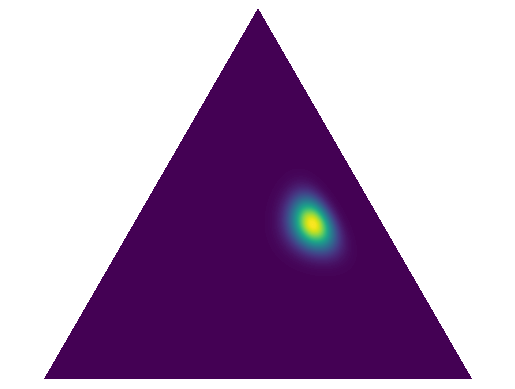

In [41]:
draw_pdf_contours(Dirichlet([20, 50, 50]))

In [1]:
# 制作数据集
import sys
import os
root = "/data/public/renhaoye/morphics/"
subdirs = [os.path.join(root, d) for d in os.listdir(root) if os.path.isdir(os.path.join(root, d))]
for subdir in subdirs:
    sys.path.append(subdir)
import torch.nn as nn
import torch
import torch.nn.functional as F
from dataset.galaxy_dataset import *
from utils import schemas
from utils.utils import *
from models.utils import *
import random
from torch.backends import cudnn
def init_rand_seed(rand_seed):
    torch.manual_seed(rand_seed)
    torch.cuda.manual_seed(rand_seed)  # 为当前GPU设置随机种子
    torch.cuda.manual_seed_all(rand_seed)  # 为所有GPU设置随机种子
    np.random.seed(rand_seed)
    random.seed(rand_seed)
    cudnn.benchmark = False
    cudnn.deterministic = True
init_rand_seed(1926)

In [6]:
img = torch.Tensor(load_img("/data/public/renhaoye/morphics/dataset/in_decals/raw_fits/119.85429851358965_28.803799075693085.fits"))
model = torch.load("/data/public/renhaoye/morphics/pth_stn_atf/model_8.pt", map_location="cuda:0")
img.shape

torch.Size([3, 256, 256])

In [7]:
predict, stn= model(img.unsqueeze(0).to("cuda:0"))
fits.writeto(f'/data/public/renhaoye/3.fits', stn[0].cpu().detach().numpy(), overwrite=True)
predict

AssertionError: Threshold values must satisfy black < midtone < white for each channel

In [13]:
predict

tensor([[ 0.0844,  1.2757, -1.5771, -1.3011,  1.3843,  0.9935, -0.6466, -0.7398,
          0.2088,  0.6360, -2.7871, -1.2049,  1.1606,  1.4957, -0.9135, -0.5932,
          1.0557, -0.6426, -1.2695, -0.1675,  0.6589,  0.4385,  0.0532, -0.5807,
         -1.2494,  1.3543, -0.2603, -1.5440, -1.6508,  0.6221,  1.2070,  0.1339,
         -0.6582, -0.8981]], device='cuda:1', grad_fn=<AddBackward0>)

In [5]:
question_answer_pairs = gz2_pairs
dependencies = gz2_and_decals_dependencies
schema = schemas.Schema(question_answer_pairs, dependencies)
predict = softmax_output(predict,schema.question_index_groups)
predict

tensor([[ 31.8448,  69.1552,   0.0000, 100.0000,   0.0000, 100.0000,   0.0000,
          27.1717,  73.8283,   0.0000,   1.3602,   3.5490,  37.4256,  60.6652,
           0.0000,  35.5116,  65.4884,   0.0000,  20.1242,  80.8758,   0.0000,
          66.2916,  34.7084,   0.0000,   5.4730,  65.6786,  23.3587,   7.1292,
           2.3606,   0.0000,  75.2776,  19.6013,   7.1211,   0.0000]],
       device='cuda:1', grad_fn=<CopySlices>)

In [14]:
question_answer_pairs = gz2_pairs
dependencies = gz2_and_decals_dependencies
schema = schemas.Schema(question_answer_pairs, dependencies)
predict = softmax_output(predict,schema.question_index_groups)
predict

tensor([[ 65.1867,  35.8133,   0.0000, 100.0000,   0.0000, 100.0000,   0.0000,
          35.0699,  65.9301,   0.0000,   2.6829,  14.0444,  54.8705,  31.4022,
           0.0000,  37.1452,  63.8548,   0.0000,  31.2852,  69.7148,   0.0000,
          56.9487,  44.0513,   0.0000,   8.0504,  77.0389,  11.0540,   5.2938,
           2.5629,   0.0000,  82.2877,  14.9244,   4.7879,   0.0000]],
       device='cuda:1', grad_fn=<CopySlices>)

In [10]:
target_layer = list(list(model.children())[0].children())[-2]
target_layer

AdaptiveAvgPool2d(output_size=1)

In [10]:
import numpy as np

def nonlinear_function(x, y, T, degree=3):
    """
    在0<x<1，0<y<1范围内的T个坐标与(0,0)和(1,1)这T+2个点之间的非线性函数f(x)

    参数:
        x: 输入点的横坐标
        y: 输入点的纵坐标
        T: 随机生成的点的数量
        degree: 多项式的阶数，默认为3

    返回值:
        f(x): 对应于输入坐标的非线性函数值
    """
    # 生成T个随机点
    points = np.random.rand(T, 2)

    # 在点集中添加(0, 0)和(1, 1)
    points = np.vstack(([0, 0], points, [1, 1]))

    # 计算多项式系数
    coeff_x = np.polyfit(points[:, 0], points[:, 1], degree)

    # 计算对应于输入x坐标的非线性函数值
    f_x = np.polyval(coeff_x, x)

    # 将函数值限制在[0, 1]范围内
    f_x = np.clip(f_x, 0, 1)

    return f_x

# 示例用法
x = 0.5
y = 0.5
T = 10

f_x = nonlinear_function(x, y, T)
print(f"Nonlinear function value at x = {x}, y = {y}: {f_x}")


Nonlinear function value at x = 0.5, y = 0.5: 0.6230088492905557


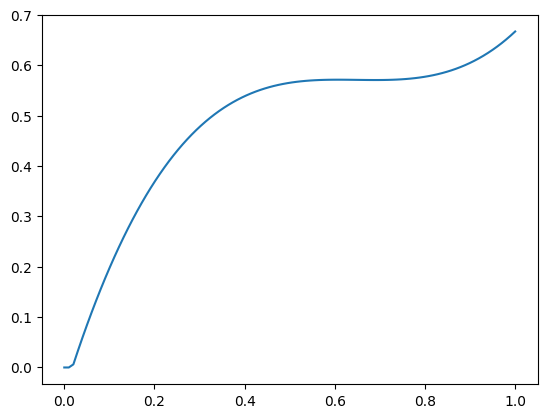

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(np.linspace(0,1,100), nonlinear_function(np.linspace(0,1,100), 0.5, 10))
plt.show()

In [3]:
import torch
import numpy as np

# 将Linear输出转换为12个点的集合
def convert_to_points(linear_output):
    points = []
    for b in range(linear_output.size(0)):
        batch_points = []
        for i in range(0, linear_output.size(1), linear_output.size(1) // 6):
            batch_points.append(torch.tensor([0, 0], dtype=torch.float32))
            batch_points += [linear_output[b, i:i+2], linear_output[b, i+2:i+4], linear_output[b, i+4:i+6], linear_output[b, i+6:i+8], linear_output[b, i+8:i+10]]
            batch_points.append(torch.tensor([1, 1], dtype=torch.float32))
        points.append(torch.stack(batch_points))
    return torch.stack(points)

# 定义非线性拟合函数
def nonlinear_function(x, points, degree=3):
    points = points.cpu().numpy()
    coeff_x = np.polyfit(points[:, 0], points[:, 1], degree)
    f_x = np.polyval(coeff_x, x.cpu().numpy())
    f_x = np.clip(f_x, 0, 1)
    return torch.tensor(f_x, dtype=torch.float32, device=x.device)

def apply_function_to_image(linear_output, input_image):
    batch_size, channels, height, width = input_image.size()
    points = convert_to_points(linear_output)

    x = torch.linspace(0, 1, width).unsqueeze(0).unsqueeze(0).unsqueeze(0).to(input_image.device)
    output_image = torch.zeros_like(input_image)
    for b in range(batch_size):
        for c in range(channels):
            group_points = points[b][c*2:(c*2)+12]
            y = nonlinear_function(x, group_points).unsqueeze(1)
            output_image[b, c] = input_image[b, c] * y

    return output_image

# 示例输入
linear_output = torch.rand(1, 66)
# input_image = torch.rand(512, 3, 256, 256)
input_image = img.unsqueeze(0)
# 应用函数到图像
output_image = apply_function_to_image(linear_output, input_image)


In [5]:
input_image

tensor([[[[ 7.5422e-04,  2.0905e-03, -1.1373e-03,  ..., -1.6273e-04,
           -5.9762e-05,  7.8630e-04],
          [ 1.7629e-03,  1.0456e-03, -3.5209e-05,  ..., -2.2789e-03,
            9.4930e-04, -6.4479e-05],
          [-7.7287e-04, -2.3586e-04,  1.0552e-04,  ...,  2.8536e-04,
            2.6506e-03,  3.5948e-04],
          ...,
          [-3.5934e-03, -3.6421e-03, -4.2399e-04,  ..., -2.1828e-04,
            4.4215e-03,  2.2618e-03],
          [ 1.7267e-03,  1.6586e-04, -1.7890e-04,  ...,  5.7658e-04,
            2.5369e-03,  2.4587e-03],
          [ 6.6345e-04,  2.8804e-03,  8.3131e-04,  ...,  1.2552e-03,
            3.8867e-04,  2.1466e-03]],

         [[-8.8761e-04, -2.7739e-04, -1.6745e-03,  ...,  7.5591e-03,
            6.1351e-03,  1.9137e-03],
          [ 2.2184e-03,  1.3861e-03, -4.1506e-03,  ...,  8.5478e-04,
            4.3388e-03, -1.4966e-03],
          [ 1.9934e-05,  4.8925e-03,  5.0644e-03,  ..., -8.3532e-04,
            2.9979e-03,  1.3901e-03],
          ...,
     

In [6]:
output_image*65535

tensor([[[[ 1.1005e+01,  3.2454e+01, -1.8700e+01,  ..., -8.8541e+00,
           -3.2779e+00,  4.3481e+01],
          [ 2.5723e+01,  1.6233e+01, -5.7893e-01,  ..., -1.2399e+02,
            5.2068e+01, -3.5656e+00],
          [-1.1277e+01, -3.6616e+00,  1.7351e+00,  ...,  1.5526e+01,
            1.4538e+02,  1.9879e+01],
          ...,
          [-5.2433e+01, -5.6541e+01, -6.9717e+00,  ..., -1.1877e+01,
            2.4251e+02,  1.2507e+02],
          [ 2.5195e+01,  2.5749e+00, -2.9417e+00,  ...,  3.1372e+01,
            1.3915e+02,  1.3596e+02],
          [ 9.6808e+00,  4.4717e+01,  1.3669e+01,  ...,  6.8294e+01,
            2.1318e+01,  1.1870e+02]],

         [[-1.9688e+01, -6.3809e+00, -3.9872e+01,  ...,  4.4000e+02,
            3.6057e+02,  1.1358e+02],
          [ 4.9206e+01,  3.1885e+01, -9.8831e+01,  ...,  4.9755e+01,
            2.5500e+02, -8.8824e+01],
          [ 4.4215e-01,  1.1254e+02,  1.2059e+02,  ..., -4.8622e+01,
            1.7619e+02,  8.2503e+01],
          ...,
     